<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# DeepDream con Python3 & Tensorflow

Proyecto elaborado por __Ezequiel Alarcon__, inove y su comunidad agradece su aporte!\
Github: https://github.com/zekalarcon/proyecto-integrador-analytics

DeepDream Actualizado a Python 3 & TensorFlow 2.x

Original: https://colab.research.google.com/drive/1DWcrN9WXni58MbddvlShX0wF_oeo8W_0#scrollTo=jQL7w_LNz1rJ

In [ ]:
# Creamos la session de tensorflow , descargamos y cargamos el modelo pre entrenado.
# El modelo se desempaca localmente en el kernel de colab. 

!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

graph = tf.Graph()

sess=tf.compat.v1.InteractiveSession(graph=graph)

with tf.compat.v2.io.gfile.GFile(model_fn, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.compat.v1.placeholder(np.float32, name='input') # definimos el input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Ayudante para obtener la capa de salida del tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2021-07-06 14:05:04--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   106MB/s    in 0.4s    

2021-07-06 14:05:05 (106 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


In [ ]:
# Funcion para ver el model summary y guardarlo en un archivo .txt 

from tensorflow.core.framework import graph_pb2
import time
import operator
import sys

def modelSummary(model_fn, output_txt_file):
    graph_def = graph_pb2.GraphDef()
    with open(model_fn, "rb") as f:
        graph_def.ParseFromString(f.read())

    tf.import_graph_def(graph_def)

    sess = tf.compat.v1.Session()
    OPS = sess.graph.get_operations()

    ops_dict = {}

    sys.stdout = open(output_txt_file, 'w')
    for i, op in enumerate(OPS):
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        print("{}: op name = {}, op type = ( {} ), inputs = {}, outputs = {}".format(i, op.name, op.type, ", ".join([x.name for x in op.inputs]), ", ".join([x.name for x in op.outputs])))
        print('@input shapes:')
        for x in op.inputs:
            print("name = {} : {}".format(x.name, x.get_shape()))
        print('@output shapes:')
        for x in op.outputs:
            print("name = {} : {}".format(x.name, x.get_shape()))
        if op.type in ops_dict:
            ops_dict[op.type] += 1
        else:
            ops_dict[op.type] = 1

    print('---------------------------------------------------------------------------------------------------------------------------------------------')
    sorted_ops_count = sorted(ops_dict.items(), key=operator.itemgetter(1))
    print('OPS counts:')
    for i in sorted_ops_count:
        print("{} : {}".format(i[0], i[1]))

In [ ]:
# Llamamos a la funcion 'modelSummary', le pasamos el modelo tensorflow .pb (model_fn),
# y el nombre del archivo .txt a guardar ('model_summary.txt').

modelSummary(model_fn,'model_summary.txt')

In [ ]:
# Cargamos la foto que deaseamos (no debe ser muy grande/pesada, de lo contrario colab se rompe cuando hace zoom in)

from google.colab import files
uploaded = files.upload()

Saving casamiento.jpg to casamiento.jpg


In [ ]:
if type(uploaded) is not dict: uploaded = uploaded.files 
file_contents = uploaded[list(uploaded.keys())[0]]

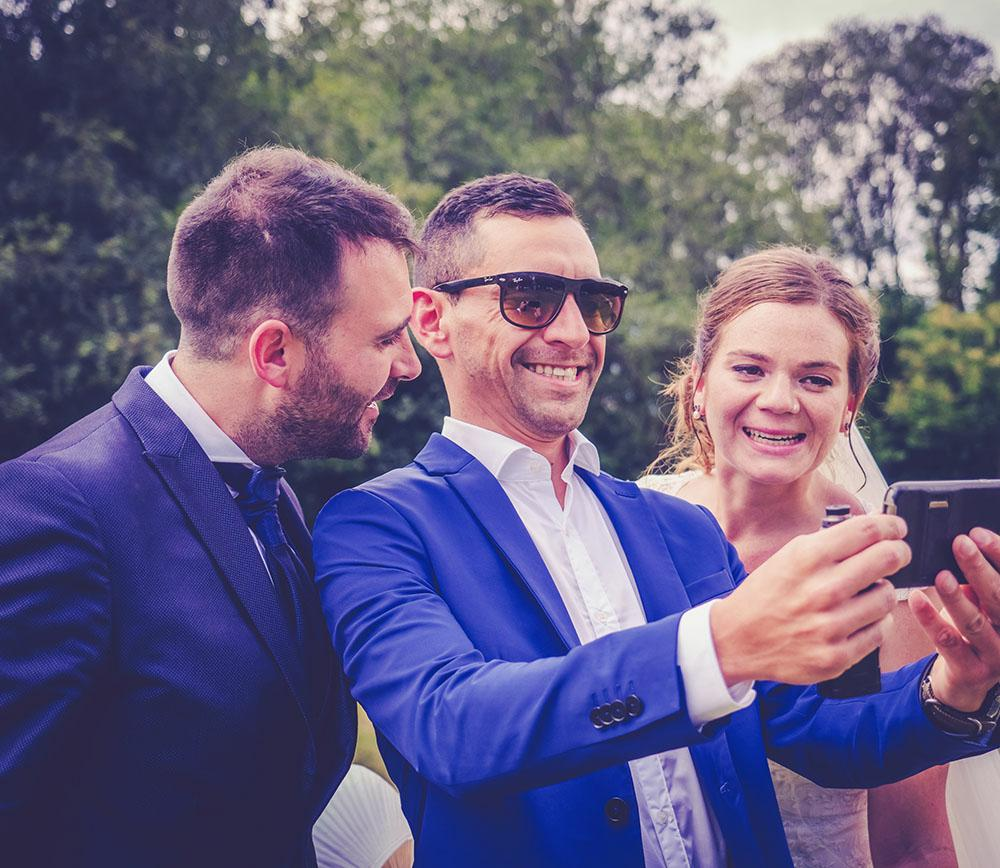

In [ ]:
# Vemos la imagen

import tensorflow as tf

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
sess = tf.compat.v1.Session()

    
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

In [ ]:
# Estos parametros nos dejan contralar la fuerza del deepdream

octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Funcion de ayuda que hace resize en la imagen utilizando tensorflow

def resize(img, new_size):
    return sess.run(tf.image.resize(img[np.newaxis,:], new_size))[0]

# Aplicamos degradados a la imagen en una serie de mosaicos.
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Se aplican cambios aleatorios a la imagen para difuminar los 
       límites de los mosaicos en múltiples iteraciones..'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # Aleatoriamente rodamos la imagen en x e y para evitar uniones entre los mosaicos.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Agregua el degradado de la imagen a la imagen y devuelve el resultado.
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Aplicamos deepdream a múltiples escalas
def render_deepdream(t_obj, input_img, show_steps = True):
    # Contraemos el objetivo de optimización a un solo número (the loss).
    t_score = tf.reduce_mean(t_obj)
    # Necesitamos el degradado de la imagen con respecto al objetivo.
    t_grad = tf.gradients(t_score, t_input)[0]

    # Dividimos la imagen en numeros de octavas (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # Generamos detalles octava a octava.
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

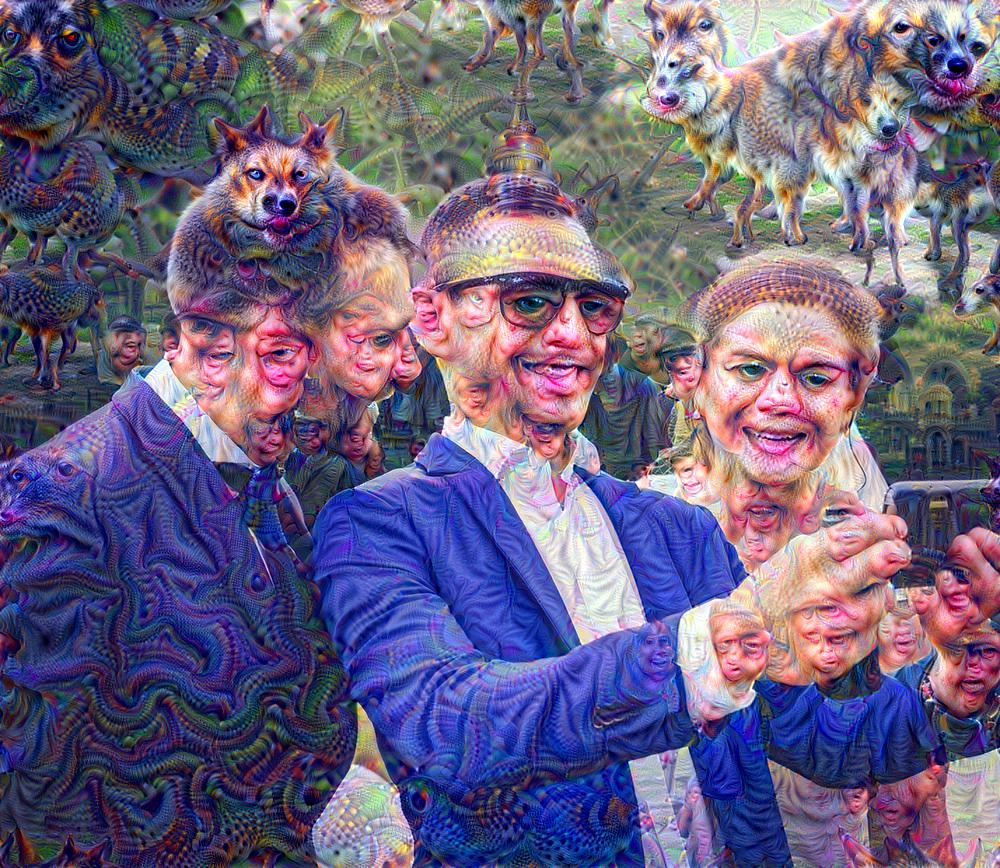

In [ ]:
# Si utilizamos las primeras capas
# (ej mixed3a ) veremos mas texturas,
# y si nos vamos mas profundo veremos 
# mas objetos/animales/personas definidas 
# (ej animales en mixed4c)
# Hay que jugar/aprender con los parametros.


octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 42 #@param {type:"slider", max: 50}
strength = 140 #@param {type:"slider", max: 1000}
layer = "mixed4c" #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a", "mixed5b_pool_reduce_pre_relu", "head1_bottleneck_pre_relu"]

final1 = render_deepdream(tf.square(T(layer)), img0)


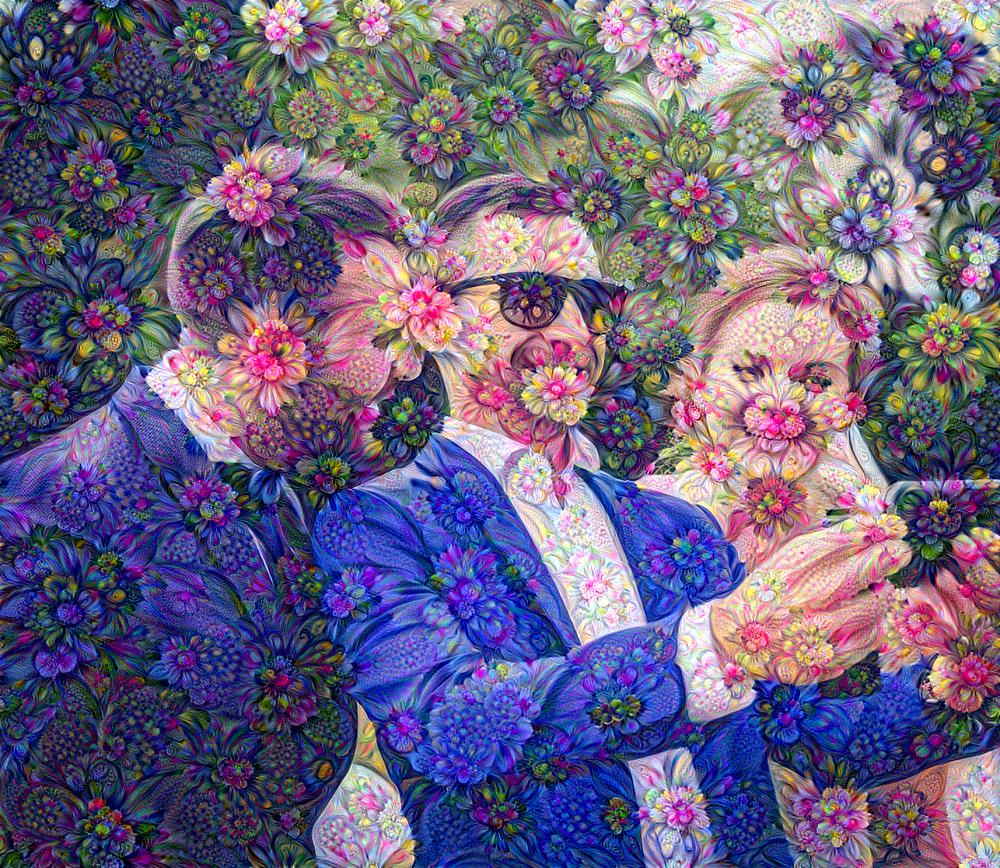

In [ ]:
# También podemos intentar optimizar 
# no contra una capa completa, sino solo 
# la actividad de una neurona.
# Tener en cuenta que toma los parametros 
# de arriba.

feature_channel = 139 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  final2 = render_deepdream(T(layer)[:,:,:,feature_channel], img0) 

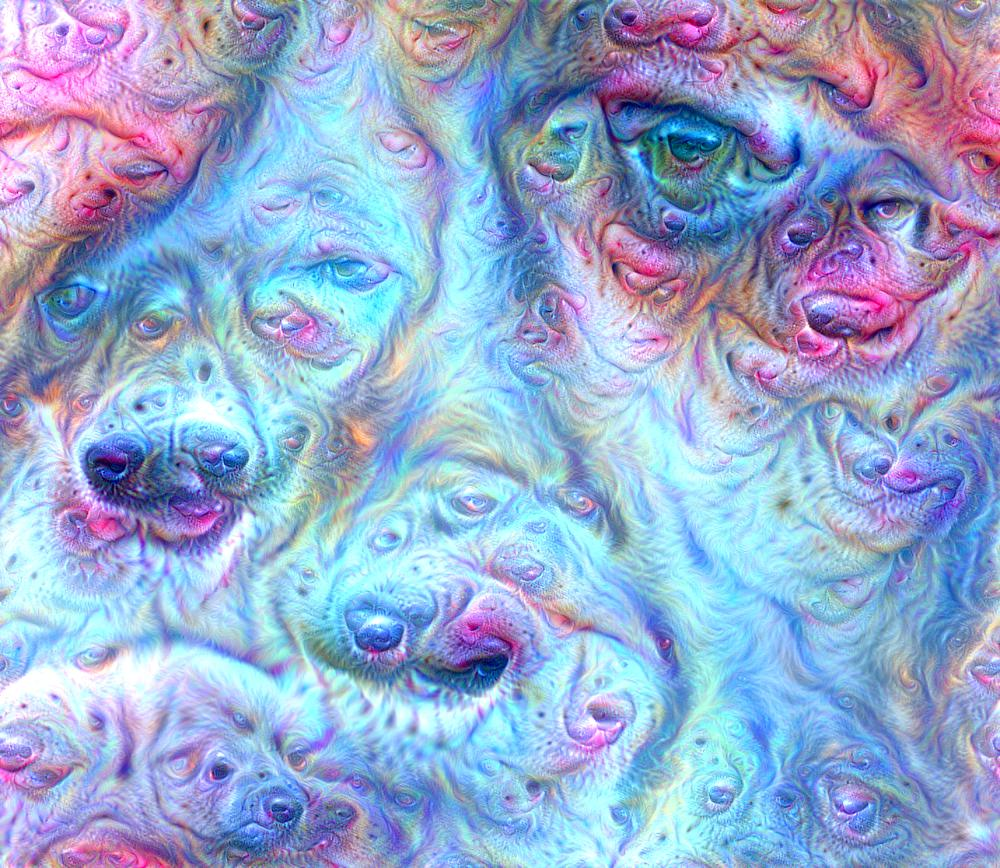

In [ ]:
# Podemos entrar en mundos completamente 
# inmersivos al sumergirnos iterativamente 
# en la imagen.


layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 16 #@param {type:"slider", max: 50}
strength = 150 #@param {type:"slider", max: 1000}
zooming_steps = 11 #@param {type:"slider", max: 512}
zoom_factor = 2.0 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]

In [ ]:
# Visualizamos el numero total de capas y sus nombres, tambien el total de feature channels.

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Numero de capas', len(layers))
print('Numero total de feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Numero de capas 59
Numero total de feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1x

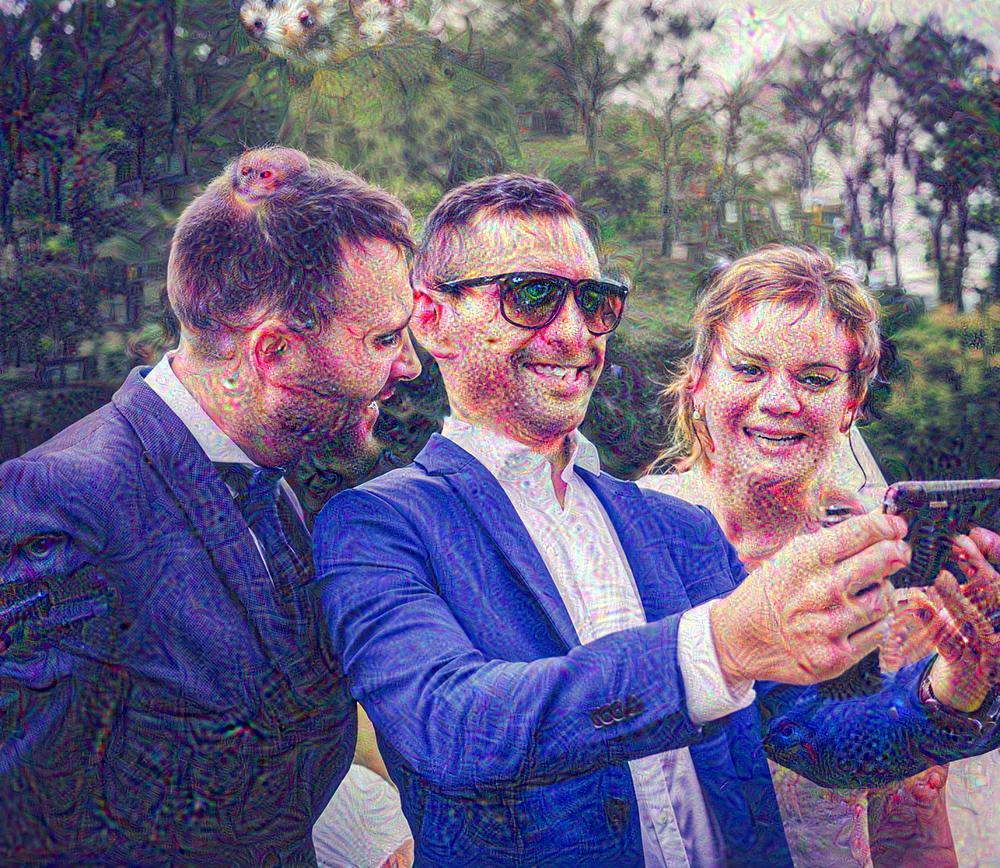

In [ ]:
# Llamamos a la funcion 'render_deepdream(tf.square(CAPA),IMG YA CARGADA)'
# le pasamos la capa que deseamos y la imagen que ya cargamos.
# Tener en cuenta que los parametros 'octave_n', 'octave_scale',
# 'iter_n', 'strength', se manejan desde el mismo bloque donde esta 
# la funcion 'render_deepdream()'.

layer = "head1_bottleneck_pre_relu"
final3 = render_deepdream(tf.square(T(layer)), img0)

In [ ]:
# Guardar imagen

def save_image(image, filename):
    # Asegurarse que los pixel-values estan entre 0 y 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convertimos imagen a bytes
    image = image.astype(np.uint8)
    
    # Escribimos el archivo de imagen en formato jpeg.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [ ]:
#  llamamos a la funcion 'save_image' para guardar las imagen.
# Imagen 1

image_save=save_image(final1,"deepdream1.jpg")

In [ ]:
# Imagen 2

image_save=save_image(final2,"deepdream2.jpg")

In [ ]:
# Imagen 3

image_save=save_image(final3,"deepdream3.jpg")

In [ ]:
# Imagen zoom-in

image_save=save_image(frame,"deepdream_zoomin.jpg")